# Global setup

In [1]:
%matplotlib inline

In [2]:
%pwd

'/home/gabe/work/fast-ai/lesson1/nbs'

### Library imports

In [3]:
import os
import sys
import json
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from importlib import reload

### Library setup

In [4]:
np.set_printoptions(precision=4, linewidth=100)
sys.path.append(r'../src')

### Local imports

In [5]:
import utils
reload(utils)

import plothelper
reload(plothelper)

import train
reload(train)

from trainhelper import *
from plothelper import *
from utils import *
from train import *

from PIL import Image

Using TensorFlow backend.


### Train model and save results

In [6]:
train_and_test(no_of_epochs=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Running epoch: 0


../src/vgg16wrapper.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  self.model = Model(inputs=img_input, output=x)


Epoch 1/1
360/360 [==============================] - 92s - loss: 0.6659 - acc: 0.9471 - val_loss: 0.5347 - val_acc: 0.9605
Completed 1 fit operations
Found 12500 images belonging to 1 classes.


(<keras.preprocessing.image.DirectoryIterator at 0x7fe25d4330b8>,
 array([[  1.0000e+00,   8.6118e-23],
        [  1.0000e+00,   0.0000e+00],
        [  0.0000e+00,   1.0000e+00],
        ..., 
        [  1.0000e+00,   0.0000e+00],
        [  1.0000e+00,   0.0000e+00],
        [  0.0000e+00,   1.0000e+00]], dtype=float32))

### Load predictions

['../data/test/unknown/532.jpg', '../data/test/unknown/10860.jpg', '../data/test/unknown/5928.jpg', '../data/test/unknown/11799.jpg', '../data/test/unknown/9775.jpg']
[[  1.0000e+00   8.6118e-23]
 [  1.0000e+00   0.0000e+00]
 [  0.0000e+00   1.0000e+00]
 [  0.0000e+00   1.0000e+00]
 [  0.0000e+00   1.0000e+00]]


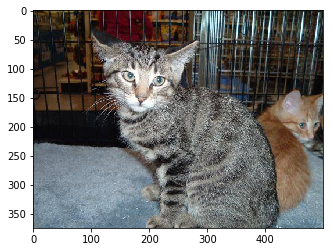

In [6]:
DATA_DIR = '../data'
TEST_DIR = DATA_DIR + '/test'

filenames, test_preds = load_pred_data()
paths = list(map(lambda x: TEST_DIR + '/' + x, filenames))

print(paths[:5])
print(test_preds[:5])

show_image(paths[1])

### Load weights and generate predictions

In [7]:
V_BATCH_SIZE = 4

t_batches = get_batches(DATA_DIR + '/train', batch_size=V_BATCH_SIZE)
v_batches = get_batches(DATA_DIR + '/valid', shuffle=False, batch_size=V_BATCH_SIZE, class_mode=None)
v_filenames = v_batches.filenames
v_classes = v_batches.classes

vgg = Vgg16()
vgg.finetune(v_batches)
vgg.model.load_weights(DATA_DIR + '/results/ft5-2017.10.01.h5')

v_steps = int(np.ceil(v_batches.samples / V_BATCH_SIZE))
v_predictions = vgg.model.predict_generator(v_batches, v_steps)

v_preds_rounded = v_predictions[:,0]
v_labels = np.round(1 - v_preds_rounded)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


../src/vgg16wrapper.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  self.model = Model(inputs=img_input, output=x)


In [8]:
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(DATA_DIR + '/valid/' + v_filenames[i]) for i in idx], titles=titles)

### Inspect correct predictions

found 1938 correct labels


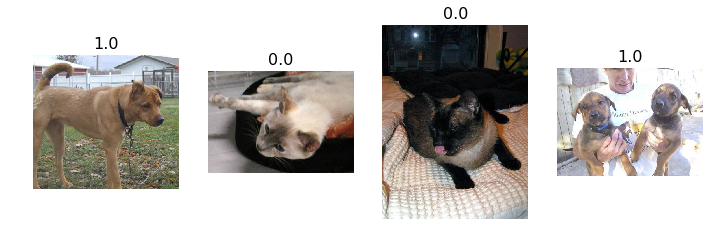

In [16]:
NUM_VIEW = 4

correct = np.where(v_labels == v_classes)[0]
print("found %d correct labels" % len(correct))

c_idx = np.random.permutation(correct)[:NUM_VIEW]
plots_idx(c_idx, v_labels[c_idx])

### Inspect incorrect predictions

found 62 incorrect labels


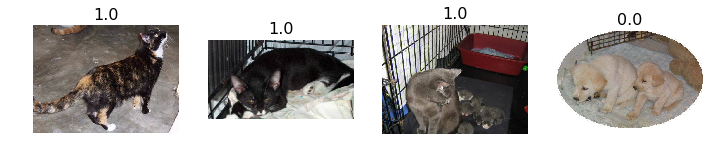

In [10]:
incorrect = np.where(v_labels != v_classes)[0]
print("found %d incorrect labels" % len(incorrect))

i_idx = np.random.permutation(incorrect)[:NUM_VIEW]
plots_idx(i_idx, v_labels[i_idx])

### Inspect incorrect cats

found 34 incorrect cats labels


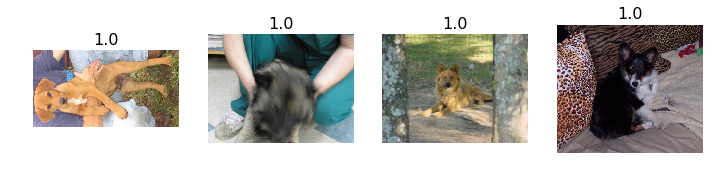

In [20]:
incorrect_cats = np.where((v_labels == 0) & (v_labels != v_classes))[0]
print("found %d incorrect cats labels" % len(incorrect_cats))

most_incorrect_cats = np.argsort(v_preds_rounded[incorrect_cats])[::-1][:NUM_VIEW]
plots_idx(incorrect_cats[most_incorrect_cats], v_preds_rounded[incorrect_cats][most_incorrect_cats])

### Inspect correct cats

found 977 confident correct cats labels


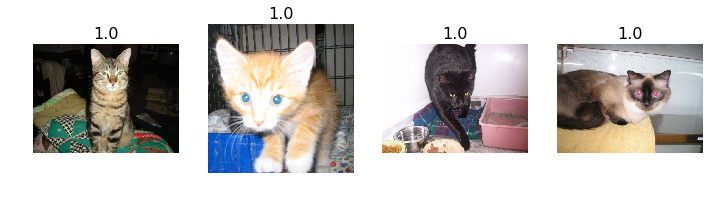

In [17]:
correct_cats = np.where((v_labels == 0) & (v_labels == v_classes))[0]
print("found %d confident correct cats labels" % len(correct_cats))

most_correct_cats = np.argsort(v_preds_rounded[correct_cats])[::-1][:NUM_VIEW]
plots_idx(correct_cats[most_correct_cats], v_preds_rounded[correct_cats][most_correct_cats])

### Inspect correct dogs

found 961 confident correct dogs labels


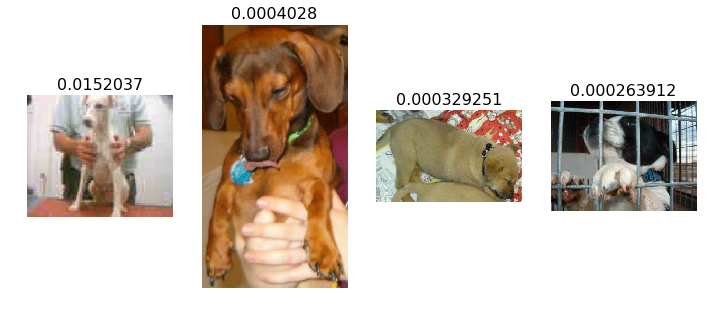

In [18]:
correct_dogs = np.where((v_labels == 1) & (v_labels == v_classes))[0]
print("found %d confident correct dogs labels" % len(correct_dogs))

most_correct_dogs = np.argsort(v_preds_rounded[correct_dogs])[::-1][:NUM_VIEW]
plots_idx(correct_dogs[most_correct_dogs], v_preds_rounded[correct_dogs][most_correct_dogs])

### Inspect incorrect dogs

found 28 incorrect dogs labels


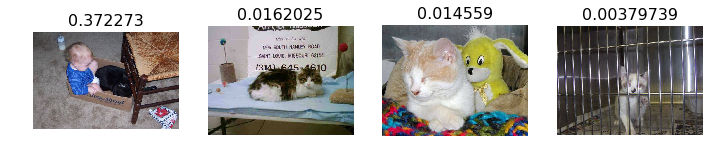

In [19]:
incorrect_dogs = np.where((v_labels == 1) & (v_labels != v_classes))[0]
print("found %d incorrect dogs labels" % len(incorrect_dogs))

most_incorrect_dogs = np.argsort(v_preds_rounded[incorrect_dogs])[::-1][:NUM_VIEW]
plots_idx(incorrect_dogs[most_incorrect_dogs], v_preds_rounded[incorrect_dogs][most_incorrect_dogs])

### Inspect most uncertain

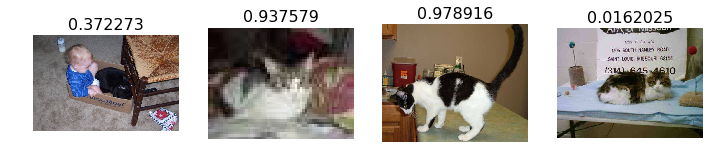

In [21]:
most_uncertain = np.argsort(np.abs(v_preds_rounded - 0.5))
plots_idx(most_uncertain[:NUM_VIEW], v_preds_rounded[most_uncertain])

### Confusion matrix

[[977  28]
 [ 34 961]]


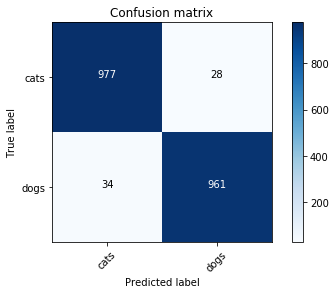

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(v_classes, v_labels)

plot_confusion_matrix(cm, v_batches.class_indices)

### Prepare submission file

In [12]:
is_dog = test_preds[:,1]

print(is_dog[:5])
print(is_dog[(is_dog < 0.6) & (is_dog > 0.4)])
print(is_dog[(is_dog == 1) & (is_dog == 0)])

[ 0.  0.  1.  1.  1.]
[ 0.5027]
[]


In [17]:
is_dog = is_dog.clip(min=0.03, max=0.97)
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

print(ids[:5], is_dog[:5])

subm = np.stack([ids, is_dog], axis=1)
print(subm[:5])

[  532 10860  5928 11799  9775] [ 0.05  0.05  0.95  0.95  0.95]
[[  5.3200e+02   5.0000e-02]
 [  1.0860e+04   5.0000e-02]
 [  5.9280e+03   9.5000e-01]
 [  1.1799e+04   9.5000e-01]
 [  9.7750e+03   9.5000e-01]]


In [18]:
np.savetxt(DATA_DIR + '/results/submission.csv', subm, fmt='%d,%.5f', header='id,label', comments='')